KẾT QUẢ CỦA CÁC MÔ HÌNH SAU KHI XỬ LÍ MẤT CÂN BẰNG:
https://drive.google.com/drive/folders/1jmeYUwPDNT5dxC1V9JZ5d1o0Mgmlhgal?usp=sharing

Dataset: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database

Covid19-XRay-w/-ML-and-DL: https://www.kaggle.com/code/thura1601/covid19-xray-w-ml-and-dl


COVID-19 Detection using X-Ray: https://www.kaggle.com/code/chiragbmiskin/covid-19-detection-using-x-ray


Tham khảo: https://www.kaggle.com/code/kaledhoshme/probabilistic-u-net-segmentation-ambiguous-images#Introduction

# **Library**

In [ ]:
from google.colab import files

import os
import pandas as pd
import numpy as np
from PIL import Image, ImageOps
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import tensorflow as tf
import pathlib

import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import torch
import torch.nn as nn
from imblearn.combine import SMOTEENN
from sklearn import metrics

from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=5)  # Khởi tạo callback 'es'

import tensorflow as tf
tf.config.run_functions_eagerly(True)


# **Step 1: Load Data**

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Chọn tệp JSON API Token từ máy tính của bạn
uploaded = files.upload()

# Di chuyển tệp JSON vào thư mục ~/.kaggle/
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
# Tải xuống bộ dữ liệu từ Kaggle
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

# Giải nén bộ dữ liệu
!unzip covid19-radiography-database.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
 

In [ ]:
# label tagging to the images
levels = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
path = "/content/COVID-19_Radiography_Dataset"
data_dir = os.path.join(path)

data = []
for id, level in enumerate(levels):
    for file in os.listdir(os.path.join(data_dir, level + '/images')):
        data.append(['{}/images/{}'.format(level, file), level])

data = pd.DataFrame(data, columns = ['image_file', 'result'])

data['path'] = path + '/' + data['image_file']

In [ ]:
data.head()

,image_file,result,path
0,Normal/images/Normal-8518.png,Normal,/content/COVID-19_Radiography_Dataset/Normal/i...
1,Normal/images/Normal-4299.png,Normal,/content/COVID-19_Radiography_Dataset/Normal/i...
2,Normal/images/Normal-6591.png,Normal,/content/COVID-19_Radiography_Dataset/Normal/i...
3,Normal/images/Normal-1375.png,Normal,/content/COVID-19_Radiography_Dataset/Normal/i...
4,Normal/images/Normal-22.png,Normal,/content/COVID-19_Radiography_Dataset/Normal/i...


# **Step 2: Analysis Data**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21165 entries, 0 to 21164
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_file  21165 non-null  object
 1   result      21165 non-null  object
 2   path        21165 non-null  object
dtypes: object(3)
memory usage: 496.2+ KB


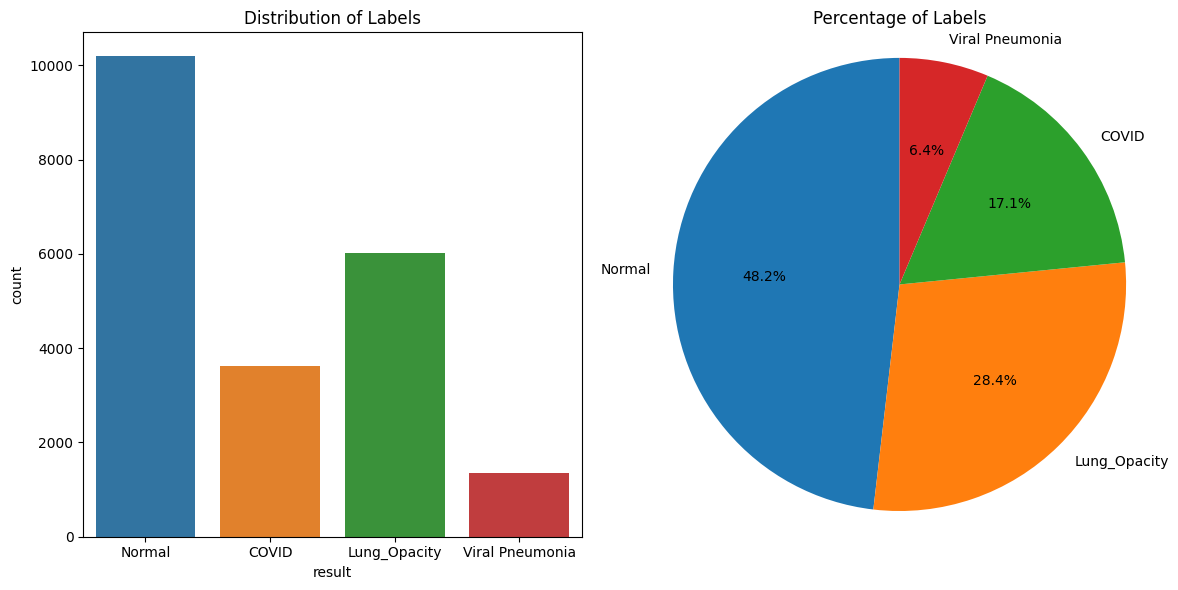

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Biểu đồ cột - Distribution of Labels
sns.countplot(x='result', data=data, ax=axes[0])
axes[0].set_title('Distribution of Labels')

# Biểu đồ tròn tỷ lệ phần trăm
label_counts = data['result'].value_counts()
axes[1].pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Percentage of Labels')
axes[1].axis('equal')  # Đảm bảo biểu đồ tròn hiển thị hình tròn

plt.tight_layout()
plt.show()

In [ ]:
data['result'].value_counts()

Normal             10192
Lung_Opacity        6012
COVID               3616
Viral Pneumonia     1345
Name: result, dtype: int64

In [ ]:
round(data['result'].value_counts() / data.shape[0] * 100,2)

Normal             48.15
Lung_Opacity       28.41
COVID              17.08
Viral Pneumonia     6.35
Name: result, dtype: float64

Dựa trên số lượng phân lớp và biểu đồ, ta có thể thấy một số nhận xét về bộ dữ liệu:
 - Số lượng ảnh trong bộ dữ liệu không đồng đều cho các lớp. Lớp "Normal" có số lượng ảnh nhiều nhất (10.192 ảnh), tiếp theo là lớp "Lung_Opacity" (6.012 ảnh), sau đó là lớp "COVID" (3.616 ảnh) và lớp "Viral Pneumonia" (1.345 ảnh). Điều này có thể gây mất cân bằng dữ liệu giữa các lớp và có thể ảnh hưởng đến hiệu suất của một số thuật toán học máy.
 - Lớp "Normal" chiếm đa số trong bộ dữ liệu, với gần một nửa số lượng ảnh. Điều này có thể tạo ra một sự mất cân bằng lớn giữa lớp "Normal" và các lớp còn lại. Trong một số trường hợp, mất cân bằng lớp như vậy có thể ảnh hưởng đến khả năng phân loại đối với các lớp thiểu số.
 - Số lượng ảnh của lớp "COVID" cũng khá đáng chú ý, nhưng vẫn thấp hơn so với lớp "Normal" và "Lung_Opacity". Điều này phản ánh việc đây là một bộ dữ liệu liên quan đến COVID-19, có thể có sự hạn chế trong việc thu thập ảnh từ các bệnh viện hoặc nguồn dữ liệu khác.
 - Lớp "Viral Pneumonia" có số lượng ảnh thấp nhất trong bộ dữ liệu, chỉ có 1.345 ảnh. Điều này có thể gây khó khăn trong việc phân loại chính xác lớp này do sự thiếu dữ liệu.
 

=> Với các nhận xét trên, cân nhắc và xử lý mất cân bằng dữ liệu, thu thập thêm ảnh cho các lớp thiểu số và kiểm tra cẩn thận sự ảnh hưởng của mất cân bằng lớp có thể giúp cải thiện hiệu suất của các mô hình học máy trong quá trình phân loại.


In [ ]:
data['result'].unique()

array(['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia'], dtype=object)

In [ ]:
data['result'].value_counts().index

Index(['Normal', 'Lung_Opacity', 'COVID', 'Viral Pneumonia'], dtype='object')

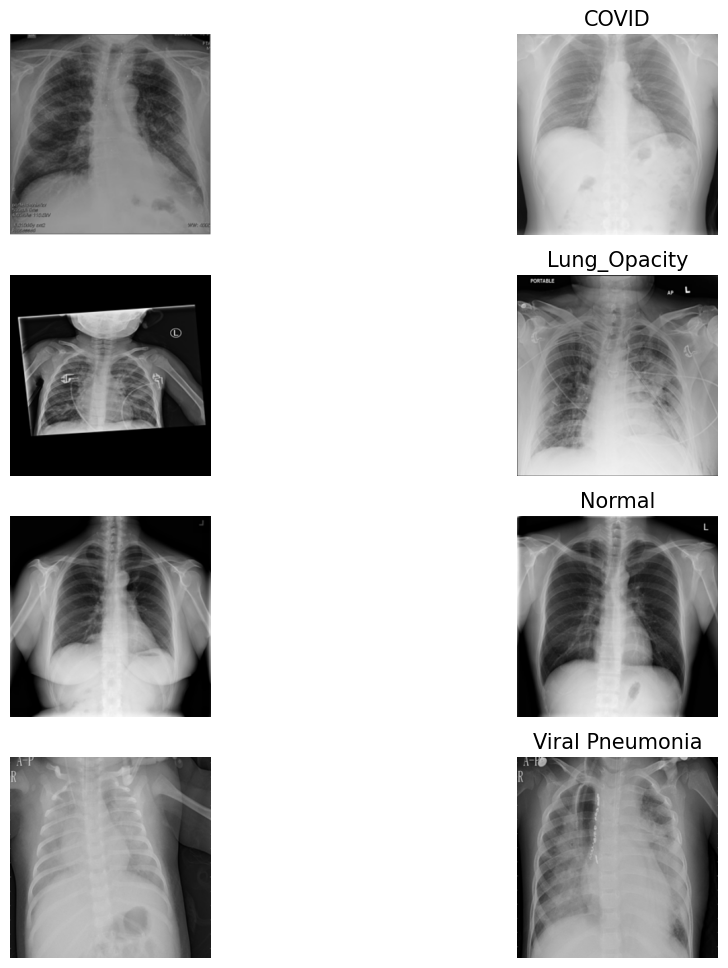

In [ ]:
#visualisation 
n_samples = 2

fig, m_axs = plt.subplots(4, n_samples, figsize = (6*n_samples, 3*4))

for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['result']).groupby('result')):
    n_axs[1].set_title(type_name, fontsize = 15)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state = 1234).iterrows()):       
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

In [ ]:
def show_images_with_masks(figure_size, masks, alpha):
    num_images = len(masks)

    fig, axes = plt.subplots(1, num_images, figsize=figure_size)

    for i in range(num_images):
        mask_path = masks[i]

        mask = cv2.imread(mask_path, 0)

        axes[i].imshow(mask, cmap='gray')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def get_mask_paths(image_file_paths):
    mask_file_paths = []
    for image_file_path in image_file_paths:
        image_path = pathlib.Path(image_file_path)
        mask_file_path = image_path.parent.parent / 'masks' / image_path.name
        mask_file_paths.append(str(mask_file_path))
    return mask_file_paths

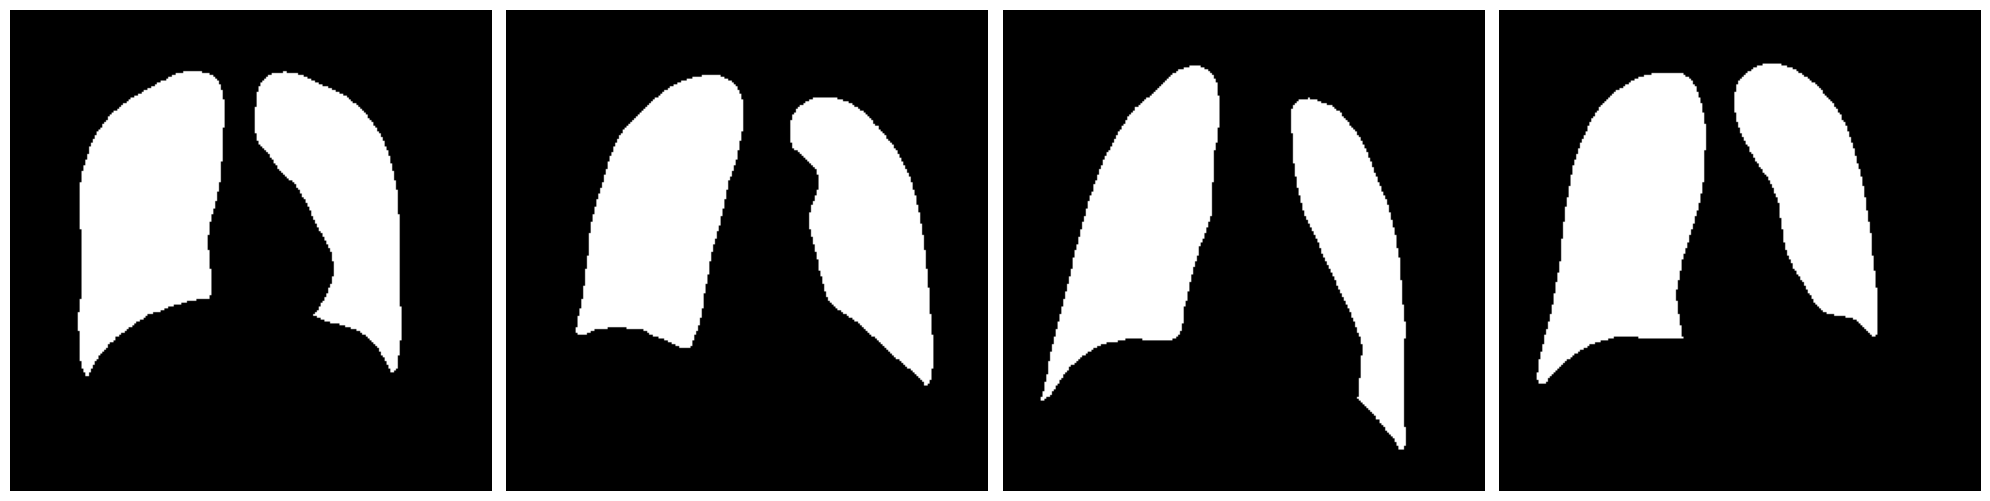

In [ ]:
# Lấy đường dẫn của images và masks

image_paths = [
    '/content/COVID-19_Radiography_Dataset/Normal/images/Normal-1.png',
    '/content/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png',
    '/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-1.png',
    '/content/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-1.png'
]

mask_paths = get_mask_paths(image_paths)

# Độ trong suốt của mặt nạ (giá trị alpha)
alpha = 0.2

show_images_with_masks((20, 20), mask_paths, alpha)

# **Step 3: Model**
- Xem kết quả 4 model ban đầu tại đây:
https://drive.google.com/file/d/1vkRCQYQxaXDIOwnXlv3_zJkAcS6LZbHL/view?usp=sharing


## **Các tiền xử lý cơ bản**

In [ ]:
pixel_img = []

for image in tqdm(data['path']):
    img=Image.open(image)
    img=ImageOps.grayscale(img)
    img=img.resize((64,64))
    img=np.asarray(img)
    img=img.reshape((64,64,1))
    pixel_img.append(img)

pixel_img = np.array(pixel_img)
label_img = data['result'].map({'Normal': 0, 'COVID': 1, 'Lung_Opacity' : 2,
                               'Viral Pneumonia' : 3})

print(pixel_img.shape, label_img.shape)

100%|██████████| 21165/21165 [00:48<00:00, 438.66it/s]


(21165, 64, 64, 1) (21165,)


In [ ]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(pixel_img, label_img, 
                                                    test_size=0.2, stratify=label_img)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pixel_img, label_img, 
                                                    test_size=0.2, stratify=label_img)

input_size = X_train.shape[1] * X_train.shape[2]
num_classes = len(np.unique(y_train))

# flatten the image
X_train = np.reshape(X_train, [X_train.shape[0], input_size])
X_train = X_train.astype('float32') / 255

X_test = np.reshape(X_test, [X_test.shape[0], input_size])
X_test = X_test.astype('float32') / 255

# **Step 4: Evaluate and perform the preprocessing**

Đừng mở ra => Khi nào cần biết pp thì mở 

In [ ]:
'''
Quan sát kết quả đánh giá của các mô hình trước khi được xử lý: 
https://colab.research.google.com/drive/1uMt2jXbfas_NnREQr2FP9VtLu9Sz6h3x?usp=sharing#scrollTo=HlnN67FHw16l
'''

Nhận xét: (Đánh giá hiệu suất trên từng lớp riêng biệt trong các mô hình)
  - Mô hình SVC:
    + Độ chính xác và độ phủ trên các lớp đều khá tương đồng, không có sự chênh lệch quá lớn.
    + F1-score cho mỗi lớp cũng khá đồng đều, không có sự chênh lệch đáng kể.
  - Mô hình RandomForestClassifier:
    + Độ chính xác và độ phủ trên lớp 1 (COVID) thấp hơn so với các lớp khác, có thể cho thấy mô hình có xuất hiện hiện tượng underfitting đối với lớp này.
    + Các lớp còn lại có độ chính xác và độ phủ tương đối tốt.
  - Mô hình XGBClassifier:
    + Độ chính xác và độ phủ trên các lớp đều cao, không có sự chênh lệch quá lớn.
    + F1-score cho mỗi lớp cũng khá đồng đều, không có sự chênh lệch đáng kể.
  - Mô hình mlp classifier:
    + Độ chính xác và độ phủ trên lớp 1 (COVID) thấp hơn so với các lớp khác, có thể cho thấy mô hình có xuất hiện hiện tượng underfitting đối với lớp này.
    + F1-score trên lớp 1 cũng thấp hơn so với các lớp khác.
  - Mô hình cnn_model1 classifier:
    + Độ chính xác và độ phủ trên các lớp đều cao, không có sự chênh lệch quá lớn.
    + F1-score cho mỗi lớp cũng khá đồng đều, không có sự chênh lệch đáng kể.
  - Mô hình cnn_model2 classifier
    + Độ chính xác và độ phủ trên các lớp đều cao và tương đối đồng đều.
    + F1-score cho mỗi lớp cũng khá đồng đều, không có sự chênh lệch đáng kể.

=> Tổng quan, mô hình SVC, XGBClassifier, cnn_model1, cnn_model2 classifier có hiệu suất tốt trên các lớp, không xuất hiện hiện tượng overfitting hoặc underfitting đáng kể. Tuy nhiên, mô hình RandomForestClassifier và mlp classifier có thể gặp hiện tượng underfitting đối với lớp COVID (class 1).

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import torch
import torch.nn as nn
from imblearn.combine import SMOTEENN

In [ ]:
class_labels = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
class_indices = {label: i for i, label in enumerate(class_labels)}

# Đếm số lượng mẫu trong từng lớp
train_class_counts = np.bincount(y_train)

# In ra số lượng mẫu của mỗi lớp
for label, count in zip(class_labels, train_class_counts):
    class_index = class_indices[label]
    print(f"Class '{label}' ({class_index}) has {count} samples in the training set.")

Class 'Normal' (0) has 8154 samples in the training set.
Class 'COVID' (1) has 2893 samples in the training set.
Class 'Lung_Opacity' (2) has 4809 samples in the training set.
Class 'Viral Pneumonia' (3) has 1076 samples in the training set.


In [ ]:
len(X_train)

16932

## **4.1. Oversampling Method**

In [ ]:
'''

'''
# Xác định số lượng mẫu trong từng lớp
num_samples = y_train.value_counts().to_dict()

# Tìm lớp có số lượng mẫu lớn nhất
max_samples = max(num_samples.values())

# Xác định tỷ lệ oversampling cho từng lớp
oversampling_ratio = 2
sampling_strategy = {}
for label, count in num_samples.items():
    oversampling_count = count * oversampling_ratio
    sampling_strategy[label] = oversampling_count


over_sampler = RandomOverSampler(sampling_strategy=sampling_strategy)
X_oversampling, y_oversampling = over_sampler.fit_resample(X_train, y_train)

In [ ]:
len(X_oversampling)

33864

## **4.2. Undersampling Method**

Bỏ

In [ ]:
'''

'''
# Xác định số lượng mẫu trong từng lớp
num_samples = y_train.value_counts().to_dict()

# Tìm lớp có số lượng mẫu ít nhất
min_samples = min(num_samples.values())

# Xác định tỷ lệ undersampling cho từng lớp
sampling_strategy = {}
for label, count in num_samples.items():
    undersampling_ratio = count // min_samples
    sampling_strategy[label] = undersampling_ratio

under_sampler = RandomUnderSampler(sampling_strategy=sampling_strategy)
X_undersampling, y_undersampling = under_sampler.fit_resample(X_train, y_train)

In [ ]:
len(X_undersampling)

14

## **4.3. Kết hợp Oversampling và Undersampling**

In [ ]:
'''
Phương pháp SMOTEENN (Synthetic Minority Over-sampling Technique + Edited Nearest Neighbors):
Với phương pháp SMOTE được sử dụng để tạo thêm các mẫu nhân tạo cho lớp thiểu số, 
trong khi phương pháp Edited Nearest Neighbors (ENN) được sử dụng để loại bỏ các mẫu gần lớp đa số có khả năng gây nhầm lẫn.
'''
sampler = SMOTEENN()
X_over_under_sampling, y_over_under_sampling = sampler.fit_resample(X_train, y_train)

In [ ]:
len(X_over_under_sampling)

25492

## **4.4. Weighted Loss Function**

Tính toán trọng số mất mát cho từng lớp dựa trên tỷ lệ số lượng mẫu của các lớp. 

Trọng số này được sử dụng để điều chỉnh quá trình huấn luyện sao cho mô hình tập trung nhiều hơn vào lớp thiểu số.

In [ ]:
def compute_class_weights(labels):
    labels_tensor = torch.tensor(labels.values)

    # Tính toán tỷ lệ số lượng mẫu của các lớp
    class_counts = torch.bincount(labels_tensor)
    total_samples = labels_tensor.size(0)
    class_weights = total_samples / (class_counts.float() + 1e-6)

    return class_weights

# Sử dụng trọng số mất mát trong quá trình huấn luyện
class_weights = compute_class_weights(y_train)
criterion = nn.CrossEntropyLoss(weight=class_weights)

## **4.5. Kết hợp giữa Oversampling và Weighted Sampling**

Bỏ

In [ ]:
def oversample_and_adjust_weights(X_train, y_train):
    # Tính toán số lượng mẫu của mỗi lớp
    class_counts = np.bincount(y_train)
    target_size = np.max(class_counts)

    balanced_X = []
    balanced_y = []

    for label, count in enumerate(class_counts):
        if count < target_size:
            # Tính toán trọng số mẫu cho lớp hiện tại dựa trên thuộc tính của hình ảnh
            sample_weights = np.array([x.shape[0] for x in X_train[y_train == label]], dtype=np.float64)
            sample_weights += 4e-2 if count < target_size else 1e-1

            # Oversample
            oversampled_indices = np.random.choice(np.where(y_train == label)[0], target_size - count, replace=True, p=sample_weights / sample_weights.sum())
            oversampled_samples = X_train[oversampled_indices]

            balanced_X.append(oversampled_samples)
            balanced_y.append(np.full(target_size - count, label))

    balanced_X = np.concatenate(balanced_X, axis=0)
    balanced_y = np.concatenate(balanced_y, axis=0)

    return balanced_X, balanced_y


balanced_X, balanced_y = oversample_and_adjust_weights(X_train, y_train)

In [ ]:
len(balanced_y)

15684

## **4.6. Data Augmentation**


In [ ]:
# Khởi tạo đối tượng ImageDataGenerator với các tham số tùy chỉnh
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

# Tái hình dạng X_train thành mảng 4D
X_train = X_train.reshape(X_train.shape[0], 64, 64, 1)

# Áp dụng Data Augmentation lên dữ liệu huấn luyện
augmented_data = datagen.flow(X_train, y_train, batch_size=32)
X_batch, y_batch = augmented_data.next()

In [ ]:
len(X_batch)

32

# **5. Model**

In [ ]:
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=5)  # Khởi tạo callback 'es'

import tensorflow as tf
tf.config.run_functions_eagerly(True)

## **5.1. Sử dụng phương pháp Oversampling trên các mô hình**

Chưa thấy link RandomForest, Xgb

In [ ]:
'''
SVM: https://colab.research.google.com/drive/1T7WhuwD-FgkSS4__QyqeRNvHlbZeFrBv?usp=sharing
RandomForest: 
Xgb: 

MLP: https://drive.google.com/file/d/1A0xnb6gCT0ngxdC5dLUouv-BfQngTV19/view?usp=drive_link
ConvNet CNN1, CNN2: https://colab.research.google.com/drive/1qi3t760nCDLogYnDwuHTGpVKAPLa52De?usp=drive_link
'''

## **5.3. Kết hợp Oversampling và Undersampling**

Chưa thấy link Xgb

In [ ]:
'''
SVM: https://colab.research.google.com/drive/1z4UG3dwTTs1c2Zve1B8z3_oZ4UKw1cOV?ouid=115358575042513490614&usp=drive_link
RandomForest: https://drive.google.com/file/d/1fXlMbLCJCZGDJMZKz-txof-5AYvK5Sqc/view?usp=drive_link
Xgb: 

MLP: https://drive.google.com/file/d/1A0xnb6gCT0ngxdC5dLUouv-BfQngTV19/view?usp=drive_link
ConvNet CNN1, CNN2: https://colab.research.google.com/drive/1qi3t760nCDLogYnDwuHTGpVKAPLa52De?usp=drive_link
'''

## **5.4.a. Sử dụng phương pháp Weighted Loss Function trên các mô hình (Dựa trên class)**

Full không link

In [ ]:
from sklearn.utils import compute_class_weight
from keras import backend as K
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import svm
from sklearn.svm import SVC

### **CÁC MODEL MACHINE LEARNING**

#### **Mô hình SVM**

In [ ]:
#20% will be used for test
X_train, X_test, y_train, y_test = train_test_split(pixel_img, label_img, 
                                                    test_size=0.2, stratify=label_img)
# flatten the image
X_train = np.reshape(X_train, [X_train.shape[0], input_size])
X_train = X_train.astype('float32') / 255

X_test = np.reshape(X_test, [X_test.shape[0], input_size])
X_test = X_test.astype('float32') / 255

# Tính toán trọng số lớp
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

# Chuyển đổi trọng số lớp thành một từ điển
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Khởi tạo và huấn luyện mô hình SVM
svm_model3 = SVC(kernel='rbf', class_weight=class_weights_dict)
svm_model3.fit(X_train, y_train)

SVC(class_weight={0: 0.5191317144959529, 1: 1.4631870031109575,
                  2: 0.8802245789145352, 3: 3.934014869888476})

In [ ]:
# predict
y_pred = svm_model3.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")
print(f"Classification report for classifier {svm_model3}:\n"
      f"{metrics.classification_report(y_test, y_pred)}\n")

Accuracy: 0.8322702575005906
Classification report for classifier SVC(class_weight={0: 0.5191317144959529, 1: 1.4631870031109575,
                  2: 0.8802245789145352, 3: 3.934014869888476}):
              precision    recall  f1-score   support

           0       0.89      0.86      0.88      2038
           1       0.71      0.80      0.76       723
           2       0.82      0.77      0.79      1203
           3       0.83      0.96      0.89       269

    accuracy                           0.83      4233
   macro avg       0.81      0.85      0.83      4233
weighted avg       0.84      0.83      0.83      4233




In [ ]:
import joblib

# save
joblib.dump(svm_model3, "/content/Model/model_svm_Weighted_Loss_class.pkl")

['/content/Model/model_svm_Weighted_Loss.pkl']

#### **Mô hình RandomF**

In [ ]:
# Khởi tạo và huấn luyện mô hình RandomForestClassifier
rf_model3 = RandomForestClassifier(n_estimators=100, n_jobs=1, class_weight=class_weights_dict)
rf_model3.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.5191317144959529,
                                     1: 1.4631870031109575,
                                     2: 0.8802245789145352,
                                     3: 3.934014869888476},
                       n_jobs=1)

In [ ]:
# predict
y_pred = rf_model3.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")
print(f"Classification report for classifier {rf_model3}:\n"
      f"{metrics.classification_report(y_test, y_pred)}\n")

Accuracy: 0.8384124734231042
Classification report for classifier RandomForestClassifier(class_weight={0: 0.5191317144959529,
                                     1: 1.4631870031109575,
                                     2: 0.8802245789145352,
                                     3: 3.934014869888476},
                       n_jobs=1):
              precision    recall  f1-score   support

           0       0.82      0.93      0.87      2038
           1       0.90      0.71      0.79       723
           2       0.83      0.77      0.80      1203
           3       0.93      0.79      0.85       269

    accuracy                           0.84      4233
   macro avg       0.87      0.80      0.83      4233
weighted avg       0.84      0.84      0.84      4233




In [ ]:
import joblib

# save
joblib.dump(rf_model3, "/content/Model/model_rf_Weighted_Loss_class.pkl")

['/content/Model/model_rf_Weighted_Loss.pkl']

#### **Mô hình XGB**

In [ ]:
# Khởi tạo và huấn luyện mô hình XGBoost với trọng số lớp cân bằng
xgb_model3 = xgb.XGBClassifier(objective="binary:logistic", random_state=42, scale_pos_weight=class_weights_dict)
xgb_model3.fit(X_train, y_train)

[03:26:24] WARNING: ../src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
# predict
y_pred = xgb_model3.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")
print(f"Classification report for classifier {xgb_model3}:\n"
      f"{metrics.classification_report(y_test, y_pred)}\n")

Accuracy: 0.8830616583982991
Classification report for classifier XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...):
              precision    recall  f1-score   support

           0       0.87      0.94      0.91      2038
           1       0.94      0.83      0.88       723
         

In [ ]:
import joblib

# save
joblib.dump(xgb_model3, "/content/Model/model_xgb_Weighted_Loss_class.pkl")

['/content/Model/model_xgb_Weighted_Loss.pkl']

### **CÁC MODEL NETWORK**

#### **Mô hình MLP (Multi-Layer Perceptron)**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pixel_img, label_img, test_size=0.2, stratify=label_img)

# Chuyển đổi nhãn thành dạng one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

# MLP
# Tiền xử lý cho X_train
X_train = X_train.reshape(X_train.shape[0], -1)  # flatten image thành 1D vector
X_train = X_train.astype('float32') / 255.0

# Tiền xử lý cho X_test
X_test = X_test.reshape(X_test.shape[0], -1)  # flatten image thành 1D vector
X_test = X_test.astype('float32') / 255.0

input_size = X_train.shape[1]
num_classes = 4

In [ ]:
# Tính toán class weights dựa trên tần suất xuất hiện của từng lớp trong tập huấn luyện
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(label_img), y=label_img)
class_weights = dict(enumerate(class_weights))

# MLP with ReLU and dropout
mlp_model = Sequential()
mlp_model.add(Dense(256, input_dim=input_size))
mlp_model.add(Activation('relu'))
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(num_classes))
mlp_model.add(Activation('softmax'))

mlp_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
               metrics=['accuracy'])


# Huấn luyện mô hình với Weighted Loss Function
mlp_model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test), class_weight=class_weights)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/50
133/133 [==============================] - 5s 36ms/step - loss: 1.5435 - accuracy: 0.4429 - val_loss: 1.0653 - val_accuracy: 0.4763
Epoch 2/50
133/133 [==============================] - 4s 28ms/step - loss: 0.9749 - accuracy: 0.5356 - val_loss: 0.8550 - val_accuracy: 0.6631
Epoch 3/50
133/133 [==============================] - 4s 30ms/step - loss: 0.9071 - accuracy: 0.5586 - val_loss: 1.0068 - val_accuracy: 0.5372
Epoch 4/50
133/133 [==============================] - 5s 36ms/step - loss: 0.8754 - accuracy: 0.5664 - val_loss: 0.8411 - val_accuracy: 0.6352
Epoch 5/50
133/133 [==============================] - 4s 31ms/step - loss: 0.8525 - accuracy: 0.5717 - val_loss: 0.9609 - val_accuracy: 0.5653
Epoch 6/50
133/133 [==============================] - 4s 31ms/step - loss: 0.8387 - accuracy: 0.5697 - val_loss: 0.9290 - val_accuracy: 0.5809
Epoch 7/50
133/133 [==============================] - 5s 41ms/step - loss: 0.8315 - accuracy: 0.5801 - val_loss: 1.0231 - val_accuracy: 0.4956

In [ ]:
loss, acc = mlp_model.evaluate(X_test, y_test, verbose=0)

print("Accuracy model8 adam: %.2f%%" % (100.0 * acc))

predictions = mlp_model.predict(X_test)
pd.crosstab(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))

Accuracy model8 adam: 69.69%
133/133 [==============================] - 1s 4ms/step


col_0,0,1,2,3
row_0,,,,
0,1313,285,330,110
1,66,485,166,6
2,119,166,900,18
3,1,9,7,252


In [ ]:
mlp_model.save('/content/Model/mlp_model_Weighted_Loss_class.h5')

In [ ]:
print("Classification report for classifier :\n"
      f"{metrics.classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))}\n")

Classification report for classifier :
              precision    recall  f1-score   support

           0       0.88      0.64      0.74      2038
           1       0.51      0.67      0.58       723
           2       0.64      0.75      0.69      1203
           3       0.65      0.94      0.77       269

    accuracy                           0.70      4233
   macro avg       0.67      0.75      0.70      4233
weighted avg       0.73      0.70      0.70      4233




#### **Mô hình ConvNet - CNN model1**

In [ ]:
# Bước tiền xử lý
X_train, X_test, y_train, y_test = train_test_split(pixel_img, label_img, test_size=0.2, stratify=label_img)

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
input_shape = (X_train.shape[1], X_train.shape[2], 1)
num_classes = 4

In [ ]:
# Tính toán trọng số mất mát
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(label_img), y=label_img)
class_weights_tensor = tf.constant(class_weights, dtype=tf.float32)
weighted_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

# Mô hình ConvNet
cnn_model1 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235), 
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Flatten(),
        layers.Dropout(0.5, seed=235),
        layers.Dense(512, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

# Compile mô hình với trọng số mất mát
cnn_model1.compile(optimizer='adam', loss=weighted_loss, metrics=['accuracy'])

# Huấn luyện mô hình
history = cnn_model1.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test), callbacks=[es])

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
530/530 [==============================] - 48s 91ms/step - loss: 0.8779 - accuracy: 0.6430 - val_loss: 0.6873 - val_accuracy: 0.7163
Epoch 2/10
530/530 [==============================] - 45s 84ms/step - loss: 0.6648 - accuracy: 0.7346 - val_loss: 0.5457 - val_accuracy: 0.7897
Epoch 3/10
530/530 [==============================] - 44s 82ms/step - loss: 0.5823 - accuracy: 0.7739 - val_loss: 0.5178 - val_accuracy: 0.8032
Epoch 4/10
530/530 [==============================] - 45s 85ms/step - loss: 0.5283 - accuracy: 0.7958 - val_loss: 0.4854 - val_accuracy: 0.8167
Epoch 5/10
530/530 [==============================] - 46s 86ms/step - loss: 0.4802 - accuracy: 0.8175 - val_loss: 0.4231 - val_accuracy: 0.8446
Epoch 6/10
530/530 [==============================] - 43s 81ms/step - loss: 0.4478 - accuracy: 0.8300 - val_loss: 0.4099 - val_accuracy: 0.8469
Epoch 7/10
530/530 [==============================] - 43s 82ms/step - loss: 0.4308 - accuracy: 0.8323 - val_loss: 0.3764 - val_accuracy:

In [ ]:
loss, acc = cnn_model1.evaluate(X_test, y_test, verbose=0)

print("Accuracy model8 adam: %.2f%%" % (100.0 * acc))

predictions = cnn_model1.predict(X_test)
pd.crosstab(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))

Accuracy model8 adam: 87.12%
133/133 [==============================] - 1s 10ms/step


col_0,0,1,2,3
row_0,,,,
0,1883,45,100,10
1,63,589,67,4
2,219,22,962,0
3,8,4,3,254


In [ ]:
cnn_model1.save('/content/Model/cnn_model1_Weighted_Loss_class.h5')

In [ ]:
print("Classification report for classifier :\n"
      f"{metrics.classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))}\n")

Classification report for classifier :
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      2038
           1       0.89      0.81      0.85       723
           2       0.85      0.80      0.82      1203
           3       0.95      0.94      0.95       269

    accuracy                           0.87      4233
   macro avg       0.89      0.87      0.88      4233
weighted avg       0.87      0.87      0.87      4233




#### **Mô hình ConvNet - CNN model2**

In [ ]:
# Bước tiền xử lý - Giống CNN model1
'''
X_train, X_test, y_train, y_test = train_test_split(pixel_img, label_img, test_size=0.2, stratify=label_img)

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
input_shape = (X_train.shape[1], X_train.shape[2], 1)
num_classes = y_train.shape[1]
'''

In [ ]:
# Tính toán trọng số mất mát
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(label_img), y=label_img)
class_weights_tensor = tf.constant(class_weights, dtype=tf.float32)
weighted_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

# Mô hình ConvNet
cnn_model2 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235), 
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Flatten(),
        layers.Dropout(0.5, seed=235),
        layers.Dense(512, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

# Compile mô hình với trọng số mất mát
cnn_model2.compile(optimizer='adam', loss=weighted_loss, metrics=['accuracy'])

# Huấn luyện mô hình
history = cnn_model2.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test), callbacks=[es])

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
530/530 [==============================] - 51s 96ms/step - loss: 1.0498 - accuracy: 0.5562 - val_loss: 0.8098 - val_accuracy: 0.6641
Epoch 2/10
530/530 [==============================] - 53s 101ms/step - loss: 0.7654 - accuracy: 0.6918 - val_loss: 0.7274 - val_accuracy: 0.7295
Epoch 3/10
530/530 [==============================] - 51s 96ms/step - loss: 0.6965 - accuracy: 0.7258 - val_loss: 0.6361 - val_accuracy: 0.7579
Epoch 4/10
530/530 [==============================] - 51s 96ms/step - loss: 0.6258 - accuracy: 0.7550 - val_loss: 0.5491 - val_accuracy: 0.8060
Epoch 5/10
530/530 [==============================] - 65s 123ms/step - loss: 0.5546 - accuracy: 0.7853 - val_loss: 0.4545 - val_accuracy: 0.8254
Epoch 6/10
530/530 [==============================] - 51s 95ms/step - loss: 0.5215 - accuracy: 0.7988 - val_loss: 0.4526 - val_accuracy: 0.8266
Epoch 7/10
530/530 [==============================] - 54s 103ms/step - loss: 0.4935 - accuracy: 0.8112 - val_loss: 0.4351 - val_accura

In [ ]:
loss, acc = cnn_model2.evaluate(X_test, y_test, verbose=0)

print("Accuracy model8 adam: %.2f%%" % (100.0 * acc))

predictions = cnn_model2.predict(X_test)
pd.crosstab(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))

Accuracy model8 adam: 85.61%
133/133 [==============================] - 2s 15ms/step


col_0,0,1,2,3
row_0,,,,
0,1920,46,69,3
1,74,601,45,3
2,270,61,870,2
3,31,2,3,233


In [ ]:
cnn_model2.save('/content/Model/cnn_model2_Weighted_Loss_class.h5')

In [ ]:
print("Classification report for classifier :\n"
      f"{metrics.classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))}\n")

Classification report for classifier :
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      2038
           1       0.85      0.83      0.84       723
           2       0.88      0.72      0.79      1203
           3       0.97      0.87      0.91       269

    accuracy                           0.86      4233
   macro avg       0.88      0.84      0.86      4233
weighted avg       0.86      0.86      0.85      4233




## **5.4.b. Sử dụng phương pháp Weighted Loss Function trên các mô hình (Dựa trên sample)**

Lặp lại model xgb 

3 model của Machine Learning trong file: 
- SVM, XGB: https://colab.research.google.com/drive/1z4UG3dwTTs1c2Zve1B8z3_oZ4UKw1cOV?ouid=115358575042513490614&usp=drive_link
- XGB: https://colab.research.google.com/drive/1T7WhuwD-FgkSS4__QyqeRNvHlbZeFrBv?ouid=115358575042513490614&usp=drive_link
- RandomF: https://drive.google.com/file/d/1fXlMbLCJCZGDJMZKz-txof-5AYvK5Sqc/view?usp=drive_link

Dưới đây sẽ chỉ là 3 model của Deep

In [ ]:
from sklearn.utils import compute_sample_weight

### **Mô hình MLP**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pixel_img, label_img, test_size=0.2, stratify=label_img)

# Chuyển đổi nhãn thành dạng one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

# MLP
# Tiền xử lý cho X_train
X_train = X_train.reshape(X_train.shape[0], -1)  # flatten image thành 1D vector
X_train = X_train.astype('float32') / 255.0

# Tiền xử lý cho X_test
X_test = X_test.reshape(X_test.shape[0], -1)  # flatten image thành 1D vector
X_test = X_test.astype('float32') / 255.0

input_size = X_train.shape[1]
num_classes = 4

# Trọng số mẫu
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [ ]:
# MLP with ReLU and dropout
mlp_model = Sequential()
mlp_model.add(Dense(256, input_dim=input_size))
mlp_model.add(Activation('relu'))
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(num_classes))
mlp_model.add(Activation('softmax'))

mlp_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
mlp_model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test), sample_weight=sample_weights)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/50
133/133 [==============================] - 6s 42ms/step - loss: 0.8497 - accuracy: 0.3509 - val_loss: 1.5983 - val_accuracy: 0.2580
Epoch 2/50
133/133 [==============================] - 4s 31ms/step - loss: 0.5967 - accuracy: 0.4676 - val_loss: 0.9173 - val_accuracy: 0.5611
Epoch 3/50
133/133 [==============================] - 4s 30ms/step - loss: 0.5703 - accuracy: 0.4855 - val_loss: 1.0092 - val_accuracy: 0.5358
Epoch 4/50
133/133 [==============================] - 6s 45ms/step - loss: 0.5528 - accuracy: 0.5012 - val_loss: 1.0434 - val_accuracy: 0.4987
Epoch 5/50
133/133 [==============================] - 4s 30ms/step - loss: 0.5383 - accuracy: 0.4934 - val_loss: 1.0517 - val_accuracy: 0.5379
Epoch 6/50
133/133 [==============================] - 4s 30ms/step - loss: 0.5242 - accuracy: 0.5014 - val_loss: 1.2131 - val_accuracy: 0.5504
Epoch 7/50
133/133 [==============================] - 5s 36ms/step - loss: 0.5201 - accuracy: 0.4985 - val_loss: 0.8619 - val_accuracy: 0.5542

In [ ]:
loss, acc = mlp_model.evaluate(X_test, y_test, verbose=0)

print("Accuracy model8 adam: %.2f%%" % (100.0 * acc))

predictions = mlp_model.predict(X_test)
pd.crosstab(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))

Accuracy model8 adam: 62.13%
133/133 [==============================] - 1s 4ms/step


col_0,0,1,2,3
row_0,,,,
0,1017,674,167,180
1,16,598,94,15
2,88,325,752,38
3,2,2,2,263


In [ ]:
mlp_model.save('/content/Model/mlp_model_Weighted_Loss_sample.h5')

In [ ]:
print("Classification report for classifier :\n"
      f"{metrics.classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))}\n")

Classification report for classifier :
              precision    recall  f1-score   support

           0       0.91      0.50      0.64      2038
           1       0.37      0.83      0.52       723
           2       0.74      0.63      0.68      1203
           3       0.53      0.98      0.69       269

    accuracy                           0.62      4233
   macro avg       0.64      0.73      0.63      4233
weighted avg       0.74      0.62      0.63      4233




### **Mô hình ConvNet - CNN model1**

In [ ]:
# Bước tiền xử lý (ConvNet)
X_train, X_test, y_train, y_test = train_test_split(pixel_img, label_img, test_size=0.2, stratify=label_img)

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
input_shape = (X_train.shape[1], X_train.shape[2], 1)
num_classes = 4

# Trọng số mẫu
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [ ]:
# Mô hình ConvNet
cnn_model1 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235), 
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Flatten(),
        layers.Dropout(0.5, seed=235),
        layers.Dense(512, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

cnn_model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình với Weighted Loss Function và trọng số mẫu
history = cnn_model1.fit(X_train, y_train, batch_size=128, epochs=50, validation_data=(X_test, y_test), sample_weight=sample_weights, callbacks=[es])

Epoch 1/50
133/133 [==============================] - 14s 103ms/step - loss: 0.6192 - accuracy: 0.4491 - val_loss: 0.9558 - val_accuracy: 0.5811
Epoch 2/50
133/133 [==============================] - 11s 83ms/step - loss: 0.4515 - accuracy: 0.5953 - val_loss: 0.7669 - val_accuracy: 0.6797
Epoch 3/50
133/133 [==============================] - 11s 83ms/step - loss: 0.3905 - accuracy: 0.6458 - val_loss: 0.6947 - val_accuracy: 0.7368
Epoch 4/50
133/133 [==============================] - 11s 82ms/step - loss: 0.3555 - accuracy: 0.6831 - val_loss: 0.5473 - val_accuracy: 0.7897
Epoch 5/50
133/133 [==============================] - 11s 81ms/step - loss: 0.3217 - accuracy: 0.7220 - val_loss: 0.6034 - val_accuracy: 0.7616
Epoch 6/50
133/133 [==============================] - 12s 92ms/step - loss: 0.2942 - accuracy: 0.7368 - val_loss: 0.5605 - val_accuracy: 0.7760
Epoch 7/50
133/133 [==============================] - 17s 126ms/step - loss: 0.2748 - accuracy: 0.7579 - val_loss: 0.4679 - val_accurac

In [ ]:
loss, acc = cnn_model1.evaluate(X_test, y_test, verbose=0)

print("Accuracy model8 adam: %.2f%%" % (100.0 * acc))

predictions = cnn_model1.predict(X_test)
pd.crosstab(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))

Accuracy model8 adam: 88.31%
133/133 [==============================] - 1s 10ms/step


col_0,0,1,2,3
row_0,,,,
0,1793,53,138,54
1,22,679,14,8
2,152,46,1001,4
3,1,3,0,265


In [ ]:
cnn_model1.save('/content/Model/cnn_model1_Weighted_Loss_sample.h5')

In [ ]:
print("Classification report for classifier :\n"
      f"{metrics.classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))}\n")

Classification report for classifier :
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      2038
           1       0.87      0.94      0.90       723
           2       0.87      0.83      0.85      1203
           3       0.80      0.99      0.88       269

    accuracy                           0.88      4233
   macro avg       0.86      0.91      0.88      4233
weighted avg       0.88      0.88      0.88      4233




### **Mô hình ConvNet - CNN model2**

In [ ]:
# Bước tiền xử lý, tính trọng số - Giống CNN model1
# Mô hình ConvNet
cnn_model2 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235), 
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Flatten(),
        layers.Dropout(0.5, seed=235),
        layers.Dense(512, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

cnn_model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình với Weighted Loss Function và trọng số mẫu
history = cnn_model2.fit(X_train, y_train, batch_size=128, epochs=50, validation_data=(X_test, y_test), sample_weight=sample_weights, callbacks=[es])

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/50
133/133 [==============================] - 13s 98ms/step - loss: 0.7443 - accuracy: 0.2642 - val_loss: 1.0484 - val_accuracy: 0.5592
Epoch 2/50
133/133 [==============================] - 14s 108ms/step - loss: 0.5478 - accuracy: 0.4941 - val_loss: 0.9999 - val_accuracy: 0.5800
Epoch 3/50
133/133 [==============================] - 13s 98ms/step - loss: 0.5101 - accuracy: 0.5174 - val_loss: 0.9388 - val_accuracy: 0.5663
Epoch 4/50
133/133 [==============================] - 13s 98ms/step - loss: 0.4763 - accuracy: 0.5540 - val_loss: 0.8674 - val_accuracy: 0.6026
Epoch 5/50
133/133 [==============================] - 14s 102ms/step - loss: 0.4462 - accuracy: 0.5793 - val_loss: 0.8648 - val_accuracy: 0.6055
Epoch 6/50
133/133 [==============================] - 14s 102ms/step - loss: 0.4254 - accuracy: 0.6055 - val_loss: 0.7741 - val_accuracy: 0.6546
Epoch 7/50
133/133 [==============================] - 13s 98ms/step - loss: 0.4056 - accuracy: 0.6248 - val_loss: 0.8607 - val_accura

In [ ]:
loss, acc = cnn_model2.evaluate(X_test, y_test, verbose=0)

print("Accuracy model8 adam: %.2f%%" % (100.0 * acc))

predictions = cnn_model2.predict(X_test)
pd.crosstab(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))

Accuracy model8 adam: 85.83%
133/133 [==============================] - 2s 12ms/step


col_0,0,1,2,3
row_0,,,,
0,1644,99,254,41
1,15,683,20,5
2,104,53,1046,0
3,4,3,2,260


In [ ]:
cnn_model2.save('/content/Model/cnn_model2_Weighted_Loss_sample.h5')

In [ ]:
0print("Classification report for classifier :\n"
      f"{metrics.classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))}\n")

Classification report for classifier :
              precision    recall  f1-score   support

           0       0.93      0.81      0.86      2038
           1       0.82      0.94      0.88       723
           2       0.79      0.87      0.83      1203
           3       0.85      0.97      0.90       269

    accuracy                           0.86      4233
   macro avg       0.85      0.90      0.87      4233
weighted avg       0.87      0.86      0.86      4233




## **5.5. Kết hợp giữa Oversampling và Weighted Sampling**

Không thấy Xgb

In [ ]:
'''
SVM: https://colab.research.google.com/drive/1z4UG3dwTTs1c2Zve1B8z3_oZ4UKw1cOV?ouid=115358575042513490614&usp=drive_link
RandomForest: https://drive.google.com/file/d/1fXlMbLCJCZGDJMZKz-txof-5AYvK5Sqc/view?usp=sharing
Xgb: 

MLP: https://drive.google.com/file/d/1A0xnb6gCT0ngxdC5dLUouv-BfQngTV19/view?usp=drive_link
ConvNet CNN1, CNN2: https://colab.research.google.com/drive/1qi3t760nCDLogYnDwuHTGpVKAPLa52De?usp=drive_link
'''

## **5.6. Sử dụng Data Augmentation trên các mô hình**

- Chỉ thực hiện trên 3 model mạng
- Full không link

### **Mô hình MLP (Multi-Layer Perceptron)**

In [ ]:
# Khởi tạo đối tượng ImageDataGenerator với các phép biến đổi tùy chỉnh
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

In [ ]:
# MLP with ReLU and dropout
mlp_model = Sequential()
mlp_model.add(Flatten(input_shape=(64, 64, 1)))
mlp_model.add(Dense(256))
mlp_model.add(Activation('relu'))
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(4))
mlp_model.add(Activation('softmax'))

mlp_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
               metrics=['accuracy'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pixel_img, label_img, 
                                                    test_size=0.2, stratify=label_img)

X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_train_reshaped = X_train_reshaped.astype('float32') / 255

X_test_reshaped = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
X_test_reshaped = X_test_reshaped.astype('float32') / 255

y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)

# Tạo dữ liệu augmentation cho X_train
augmented_X_train = datagen.flow(X_train_reshaped, y_train, batch_size=128)

# Tiến hành huấn luyện mô hình với data augmentation
mlp_model.fit(augmented_X_train, epochs=50, validation_data=(X_test_reshaped, y_test), callbacks=[es])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


133/133 [==============================] - 30s 206ms/step - loss: 1.7185 - accuracy: 0.4519 - val_loss: 0.9940 - val_accuracy: 0.5245
Epoch 2/50
133/133 [==============================] - 19s 143ms/step - loss: 1.0722 - accuracy: 0.5200 - val_loss: 0.9183 - val_accuracy: 0.6161
Epoch 3/50
133/133 [==============================] - 16s 117ms/step - loss: 1.0418 - accuracy: 0.5302 - val_loss: 0.8958 - val_accuracy: 0.6173
Epoch 4/50
133/133 [==============================] - 16s 121ms/step - loss: 1.0342 - accuracy: 0.5337 - val_loss: 0.9132 - val_accuracy: 0.6017
Epoch 5/50
133/133 [==============================] - 17s 128ms/step - loss: 1.0293 - accuracy: 0.5395 - val_loss: 0.8984 - val_accuracy: 0.6005
Epoch 6/50
133/133 [==============================] - 16s 123ms/step - loss: 1.0172 - accuracy: 0.5464 - val_loss: 0.9040 - val_accuracy: 0.5974
Epoch 7/50
133/133 [==============================] - 17s 126ms/step - loss: 1.0070 - accuracy: 0.5516 - val_loss: 0.9016 - val_accuracy: 0.5

In [ ]:
loss, acc = mlp_model.evaluate(X_test_reshaped, y_test, verbose=0)

print("Accuracy model8 adam: %.2f%%" % (100.0 * acc))

predictions = mlp_model.predict(X_test)
pd.crosstab(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))

Accuracy model8 adam: 64.16%
133/133 [==============================] - 1s 6ms/step


col_0,0,1,2,3
row_0,,,,
0,1841,1,60,136
1,601,2,116,4
2,631,3,560,9
3,40,0,19,210


In [ ]:
mlp_model.save('/content/Model/mlp_model_data_augmentation.h5')

In [ ]:
print("Classification report for classifier :\n"
      f"{metrics.classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))}\n")

Classification report for classifier :
              precision    recall  f1-score   support

           0       0.59      0.90      0.71      2038
           1       0.33      0.00      0.01       723
           2       0.74      0.47      0.57      1203
           3       0.58      0.78      0.67       269

    accuracy                           0.62      4233
   macro avg       0.56      0.54      0.49      4233
weighted avg       0.59      0.62      0.55      4233




### **Mô hình ConvNet - CNN model1**

In [ ]:
# Khởi tạo đối tượng ImageDataGenerator với các phép biến đổi tùy chỉnh
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

In [ ]:
# Xử lý trước khi đưa vào mô hình
X_train, X_test, y_train, y_test = train_test_split(pixel_img, label_img, 
                                                    test_size=0.2, stratify=label_img)

num_classes = len(np.unique(y_train))

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

input_shape = (X_train.shape[1],X_train.shape[2],1)

In [ ]:
cnn_model1 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235), 
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Flatten(),
        layers.Dropout(0.5, seed=235),
        layers.Dense(512, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
# Áp dụng Data Augmentation lên dữ liệu huấn luyện
augmented_data = datagen.flow(X_train, y_train, batch_size=128)

# Biên dịch mô hình
cnn_model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Huấn luyện mô hình với dữ liệu đã được tăng cường
history = cnn_model1.fit(augmented_data, epochs=50, validation_data=(X_test, y_test), callbacks=[es])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


133/133 [==============================] - 33s 199ms/step - loss: 1.1444 - accuracy: 0.5020 - val_loss: 0.8847 - val_accuracy: 0.6593
Epoch 2/50
133/133 [==============================] - 25s 188ms/step - loss: 0.9316 - accuracy: 0.6161 - val_loss: 0.7775 - val_accuracy: 0.6851
Epoch 3/50
133/133 [==============================] - 28s 207ms/step - loss: 0.8505 - accuracy: 0.6521 - val_loss: 0.7277 - val_accuracy: 0.6974
Epoch 4/50
133/133 [==============================] - 25s 190ms/step - loss: 0.7938 - accuracy: 0.6772 - val_loss: 0.6890 - val_accuracy: 0.7130
Epoch 5/50
133/133 [==============================] - 27s 205ms/step - loss: 0.7545 - accuracy: 0.6936 - val_loss: 0.6575 - val_accuracy: 0.7222
Epoch 6/50
133/133 [==============================] - 25s 190ms/step - loss: 0.7339 - accuracy: 0.7009 - val_loss: 0.6182 - val_accuracy: 0.7619
Epoch 7/50
133/133 [==============================] - 24s 183ms/step - loss: 0.7067 - accuracy: 0.7123 - val_loss: 0.5921 - val_accuracy: 0.7

In [ ]:
loss, acc = cnn_model1.evaluate(X_test, y_test, verbose=0)

print("Accuracy model8 adam: %.2f%%" % (100.0 * acc))

predictions = cnn_model1.predict(X_test)
pd.crosstab(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))

Accuracy model8 adam: 84.69%
133/133 [==============================] - 1s 10ms/step


col_0,0,1,2,3
row_0,,,,
0,1952,15,69,2
1,149,487,82,5
2,237,18,946,2
3,63,5,1,200


In [ ]:
cnn_model1.save('/content/Model/cnn_model1_data_augmentation.h5')

In [ ]:
print("Classification report for classifier :\n"
      f"{metrics.classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))}\n")

Classification report for classifier :
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      2038
           1       0.93      0.67      0.78       723
           2       0.86      0.79      0.82      1203
           3       0.96      0.74      0.84       269

    accuracy                           0.85      4233
   macro avg       0.89      0.79      0.83      4233
weighted avg       0.86      0.85      0.84      4233




### **Mô hình ConvNet - CNN model2**

In [ ]:
# Xử lý trước khi đưa vào mô hình
X_train, X_test, y_train, y_test = train_test_split(pixel_img, label_img, 
                                                    test_size=0.2, stratify=label_img)

num_classes = len(np.unique(y_train))

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

input_shape = (X_train.shape[1],X_train.shape[2],1)

In [ ]:
cnn_model2 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235), 
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Flatten(),
        layers.Dropout(0.5, seed=235),
        layers.Dense(512, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
# Áp dụng Data Augmentation lên dữ liệu huấn luyện
augmented_data = datagen.flow(X_train, y_train, batch_size=128)

# Biên dịch mô hình
cnn_model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Huấn luyện mô hình với dữ liệu đã được tăng cường
history = cnn_model2.fit(augmented_data, epochs=50, validation_data=(X_test, y_test), callbacks=[es])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


133/133 [==============================] - 29s 212ms/step - loss: 1.1721 - accuracy: 0.4813 - val_loss: 1.0190 - val_accuracy: 0.5923
Epoch 2/50
133/133 [==============================] - 26s 193ms/step - loss: 1.0052 - accuracy: 0.5993 - val_loss: 0.9132 - val_accuracy: 0.6454
Epoch 3/50
133/133 [==============================] - 26s 194ms/step - loss: 0.9114 - accuracy: 0.6341 - val_loss: 0.7791 - val_accuracy: 0.6797
Epoch 4/50
133/133 [==============================] - 26s 195ms/step - loss: 0.8536 - accuracy: 0.6547 - val_loss: 0.7210 - val_accuracy: 0.6957
Epoch 5/50
133/133 [==============================] - 26s 197ms/step - loss: 0.8064 - accuracy: 0.6703 - val_loss: 0.6765 - val_accuracy: 0.7165
Epoch 6/50
133/133 [==============================] - 26s 192ms/step - loss: 0.7678 - accuracy: 0.6820 - val_loss: 0.6892 - val_accuracy: 0.7231
Epoch 7/50
133/133 [==============================] - 26s 194ms/step - loss: 0.7533 - accuracy: 0.6890 - val_loss: 0.7130 - val_accuracy: 0.7

In [ ]:
loss, acc = cnn_model2.evaluate(X_test, y_test, verbose=0)

print("Accuracy model8 adam: %.2f%%" % (100.0 * acc))

predictions = cnn_model2.predict(X_test)
pd.crosstab(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))

Accuracy model8 adam: 83.94%
133/133 [==============================] - 3s 22ms/step


col_0,0,1,2,3
row_0,,,,
0,1931,0,99,8
1,157,389,155,22
2,172,9,1019,3
3,53,1,1,214


In [ ]:
cnn_model2.save('/content/Model/cnn_model2_data_augmentation.h5')

In [ ]:
print("Classification report for classifier :\n"
      f"{metrics.classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))}\n")

Classification report for classifier :
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      2038
           1       0.97      0.54      0.69       723
           2       0.80      0.85      0.82      1203
           3       0.87      0.80      0.83       269

    accuracy                           0.84      4233
   macro avg       0.87      0.78      0.81      4233
weighted avg       0.85      0.84      0.83      4233




## Thêm: **5.7. Sử dụng Data Augmentation kết hợp với Oversampling trên các mô hình**

- Chỉ thực hiện trên 3 model mạng 
- Đường dẫn: https://colab.research.google.com/drive/1mWPPMKbjyN_-9UFp0vrU7Eq6oodttp4K?usp=sharing
